# Lab Five: Wide and Deep Network Architectures
## Caleb Moore, Blake Gebhardt, Christian Gould
dataset: https://www.kaggle.com/datasets/ethanchen44/nba-playoff-predictions

In this lab, we will be using machine learning to predict the winning team of NBA playoff games. We will be using the data from the 2023 NBA season. 

In [186]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import datasets
from numpy.linalg import pinv
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

In [187]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Preparation (4 points total)
[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

### <div style="color: green">Load the data in!</div>

In [188]:
# Load the data in. Have to use latin-1 encoding because the data is encoded in that way.
df = pd.read_csv('./data/nba_games.csv', encoding='latin-1')

### <div style="color: green">Take a look at the data</div>
* Here, we can see that there are some columns that we should probably not be taking into account, because they are redundant. The columns home_team and away_team give us the same data as the columns home_team_short and away_team_short. We will drop these columns.

* the columns home_points and away_points actually give us the same data as the column winner, which is what we are trying to predict, so we will drop these columns as well.

* the matchup_id is also irrelevant, so we will drop that as well.

In [189]:
df.head()

,home_team,home_team_short,matchup_id,home_points,home_fg_pct,home_ft_pct,home_fg3_pct,away_team,away_team_short,away_points,away_fg_pct,away_ft_pct,away_fg3_pct,winning_team
0,Boston Celtics,BOS,22201216,120,0.472,0.786,0.463,Atlanta Hawks,ATL,114,0.454,0.789,0.282,BOS
1,Phoenix Suns,PHX,22201229,114,0.424,0.727,0.378,LA Clippers,LAC,119,0.490,0.667,0.217,LAC
2,Denver Nuggets,DEN,22201227,109,0.500,0.720,0.250,Sacramento Kings,SAC,95,0.435,0.667,0.256,DEN
3,Minnesota Timberwolves,MIN,22201225,113,0.476,0.710,0.361,New Orleans Pelicans,NOP,108,0.444,0.862,0.143,MIN
4,Oklahoma City Thunder,OKC,22201226,115,0.500,0.813,0.333,Memphis Grizzlies,MEM,100,0.435,0.722,0.189,OKC


### <div style="color: green">Make the necessary changes</div>
* Remove the columns that we do not need
* One hot encode the data
* Remove any n/a values

In [190]:
# drop the columns we don't need
cols_we_dont_need = ['home_team', 'away_team', 'home_points', 'away_points', 'matchup_id']
df.drop(cols_we_dont_need, axis=1, inplace=True)

# Change the winning team column to be a binary column. 1 if the home team won, 0 if the away team won
df['winning_team'] = np.where(df['home_team_short'] == df['winning_team'], 0, 1)

# Print the number of 0's and 1's in the winning_team column
print(df['winning_team'].value_counts())

# Drop the columns we don't need anymore
cols_we_dont_need = ['home_team_short', 'away_team_short']
df.drop(cols_we_dont_need, axis=1, inplace=True)

# Remove the n/a values
df = df.dropna()

# Take a look at our new dataframe
df.head()

0    1807
1    1468
Name: winning_team, dtype: int64


,home_fg_pct,home_ft_pct,home_fg3_pct,away_fg_pct,away_ft_pct,away_fg3_pct,winning_team
0,0.472,0.786,0.463,0.454,0.789,0.282,0
1,0.424,0.727,0.378,0.490,0.667,0.217,1
2,0.500,0.720,0.250,0.435,0.667,0.256,0
3,0.476,0.710,0.361,0.444,0.862,0.143,0
4,0.500,0.813,0.333,0.435,0.722,0.189,0


[1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 

### <div style="color: green">Some features that should be crossed</div>

1. __Home team shooting percentages vs. Away team shooting percentages:__

   we will create a cross-product feature by multiplying the home team's shooting percentages with the away team's shooting percentages. This could potentially capture some interaction between the two teams' shooting performances, which is something that could come into play in a game.

2. __Home team's shooting percentages vs. Away team's shooting percentages at specific distances:__

   we will create cross-product features by multiplying the home team's shooting percentage from a specific distance with the away team's shooting percentage from the same distance. For example, we can multiply the home team's field goal percentage from three-point range with the away team's three-point field goal percentage. This could potentially capture some interaction between the two teams' shooting performances from specific distances

### <div style="color: green">A feature that should not be crossed</div>
1. __Home team's shooting percentages vs. Home team's free throw percentages:__

  We will not create a cross-product feature with these two features, because it would simply not add much to the model. The home team's shooting percentages and the home team's free throw percentages are two very related features, so it would not make sense to multiply them together.



### <div style="color: green">Crossing the features we want!</div>

In [191]:
df['home_shooting_away_shooting_cross'] = df.apply(lambda row: row['home_fg_pct'] * row['away_fg_pct'], axis=1)
df['home_shooting_away_shooting_3pt_cross'] = df.apply(lambda row: row['home_fg3_pct'] * row['away_fg3_pct'], axis=1)

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### Choosing a metric

#### <div style="color: green">What is our purpose?</div>
* Before we can choose a proper metric, we need to know and define exactly what our purpose in this report is. Our purpose is to be able to take in data for two teams, and be able to predict which team will win the game.

#### <div style="color: green">Then what metric should we use?</div>
* Even though in most cases with machine learning, accuracy is not the best metric to use, in this case, it is the best metric to use, because we would want to be able to predict the winner of the game as accurately as possible. Because of the nature of this problem, there really isn't another metric that we can really use. 

* Something like precision, which would be helpful in a lot of cases, would not really be useful to us, because every game is a binary outcome, and the stats of a team is always changing. We want to be able to have a model that can predict the winner of a game, not a model that consistently picks a winner given certain conditions, regardless of who would win.

#### <div style="color: green">Our metric</div>
* So, then since we are going to be using accuracy, we will shoot for an accuracy of over 54%, since the accuracy of most sports betting systems achieve an accuracy of 54%, according to [this article](https://graham-kendall.com/blog/sports-forecasting-a-comparison-of-the-forecast-accuracy-of-prediction-markets-betting-odds-and-tipsters/).

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 


### Choosing a method for splitting the data


#### <span style="color: green">What is our purpose?</span>
* Again, before we look into splitting our data, we need to take a close look at our purpose. Since our purpose is a binary classifier, we need to make sure that both of our classes are represented equally in our training and testing data. Home teams and Away teams are in the dataset. We need to make sure that both of these classes are represented equally in our training and testing data.

#### <div style="color: green">Which classifier fulfills our purpose best?</div>
* 10-fold cross-validation is generally recommended for small to medium-sized datasets, where the goal is to maximize the use of the available data and obtain a more stable estimate of the model's performance. However, if we were using a larger dataset, it would probably be easier to use a simpler method, such as a single random split of the data into training and testing sets.

* Our dataset is not too large, so we will be using 10-fold cross-validation.

### <div style="color: green">Setup the 10 fold cross validation</div>

In [192]:
def get_acc(X, y, model):
  """
  Runs 10-fold cross-validation on the input data and model.

  Args:
  - X: A pandas DataFrame of features.
  - y: A pandas Series of target labels.
  - model: A scikit-learn model object.

  Returns:
  - number: The average accuracy score across all folds.
  """
  # Initialize the KFold object with 10 folds
  kf = KFold(n_splits=10, shuffle=True, random_state=42)

  # Initialize a list to store the accuracy scores for each fold
  scores = []

  # Loop through each fold and train/test the model
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      model.fit(X_train, y_train)
      score = model.score(X_test, y_test)
      scores.append(score)

  return np.mean(scores)

In [193]:
# Separate our X and y
X = df.drop('winning_team', axis=1)


y = df['winning_team']

# assign a number to each team name in the winning_team column
print(y)

0       0
1       1
2       0
3       0
4       0
       ..
3270    0
3271    0
3272    0
3273    1
3274    0
Name: winning_team, Length: 3271, dtype: int64


In [194]:
model = LogisticRegression()

# Print the average accuracy score over all folds for a basic linear regression model
print("Average accuracy score for basic linear regression:", get_acc(X, y, model))

Average accuracy score for basic linear regression: 0.8125932348773028


##### Sweet! We have a basic model with linear regression that already is performing pretty well. Let's see if we can improve it by using different models.

# Modeling (5 points total)
[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

In [195]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [196]:
def create_wide_and_deep_network(wide_layer_size, deep_layer_sizes):
    # Wide part of the network
    wide_input = Input(shape=(wide_layer_size,))
    
    # Deep part of the network
    deep_input = Input(shape=(deep_layer_sizes[0],))
    deep = deep_input
    for layer_size in deep_layer_sizes[1:]:
        deep = Dense(layer_size, activation='relu')(deep)

    # Combine wide and deep parts
    combined = Concatenate()([wide_input, deep])

    # Output layer
    output = Dense(1, activation='sigmoid')(combined)

    # Create the model
    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [197]:
# Width should be 3
# Depth arr should be: [8, 8, 16]

def run_wide_and_deep_network(width, depth_arr, X, y):
  # Wide part - cross-product of one-hot encoded team names
  X_wide = X.iloc[:, :width]

  # Deep part - embedding of one-hot encoded team names combined with numerical features
  X_deep = pd.concat([X.iloc[:, :width], X.iloc[:, width:]], axis=1)

  X_wide = X_wide.values
  X_deep = X_deep.values

  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  fold = 1
  histories = []
  avg_val_accuracy = []

  for train_index, val_index in skf.split(X_wide, y):
      X_wide_train, X_wide_val = X_wide[train_index], X_wide[val_index]
      X_deep_train, X_deep_val = X_deep[train_index], X_deep[val_index]
      y_train, y_val = y[train_index], y[val_index]

      model = create_wide_and_deep_network(width, depth_arr)  # Adjust the parameters based on your specific dataset
      history = model.fit([X_wide_train, X_deep_train], y_train, validation_data=([X_wide_val, X_deep_val], y_val), epochs=100, batch_size=32, verbose=0)

      histories.append(history)

      val_accuracy = history.history['val_accuracy'][-1]
      avg_val_accuracy.append(val_accuracy)

      print(f"Fold {fold} Validation Accuracy: {val_accuracy:.4f}")
      fold += 1

  print(f"Average Validation Accuracy: {np.mean(avg_val_accuracy):.4f}")

  # Plot the histories
  for history in histories:
    plot_history(history, 'Wide and Deep Network')

### <div style="color: green">Wide and Deep Network 1 </div>

Fold 1 Validation Accuracy: 0.8293
Fold 2 Validation Accuracy: 0.8073
Fold 3 Validation Accuracy: 0.7859
Fold 4 Validation Accuracy: 0.8257
Fold 5 Validation Accuracy: 0.8043
Fold 6 Validation Accuracy: 0.8226
Fold 7 Validation Accuracy: 0.8073
Fold 8 Validation Accuracy: 0.8257
Fold 9 Validation Accuracy: 0.8532
Fold 10 Validation Accuracy: 0.8624
Average Validation Accuracy: 0.8224


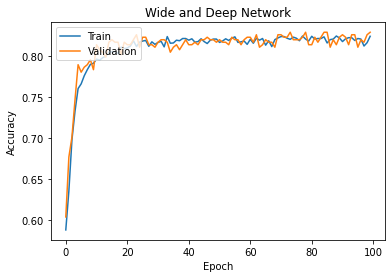

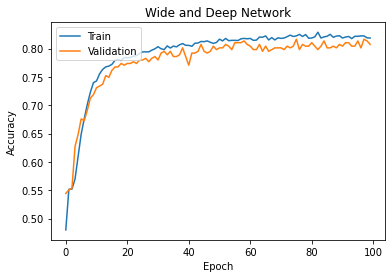

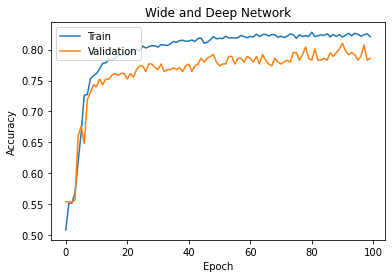

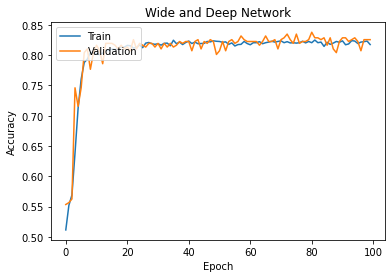

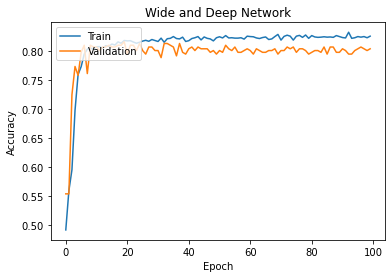

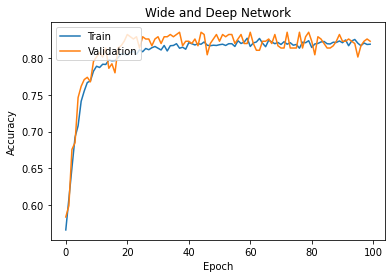

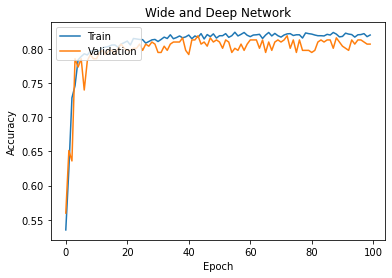

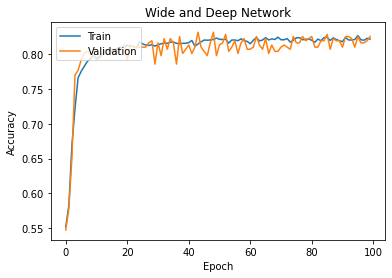

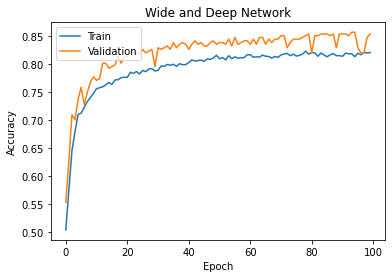

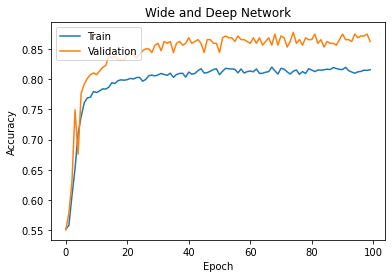

In [198]:
run_wide_and_deep_network(3, [8, 8, 16], X, y.values)

### <div style="color: green">Wide and Deep Network 2 </div>

Fold 1 Validation Accuracy: 0.8171
Fold 2 Validation Accuracy: 0.8073
Fold 3 Validation Accuracy: 0.7768
Fold 4 Validation Accuracy: 0.8226
Fold 5 Validation Accuracy: 0.8104
Fold 6 Validation Accuracy: 0.8196
Fold 7 Validation Accuracy: 0.8165
Fold 8 Validation Accuracy: 0.7982
Fold 9 Validation Accuracy: 0.8593
Fold 10 Validation Accuracy: 0.8593
Average Validation Accuracy: 0.8187


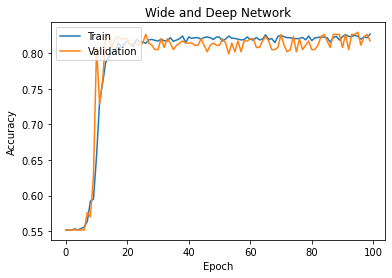

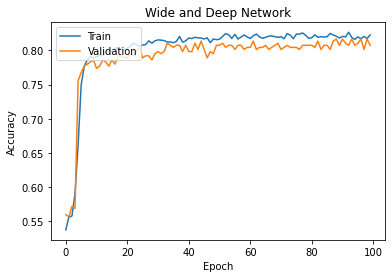

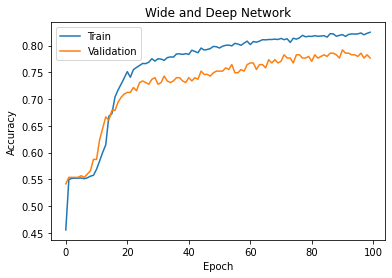

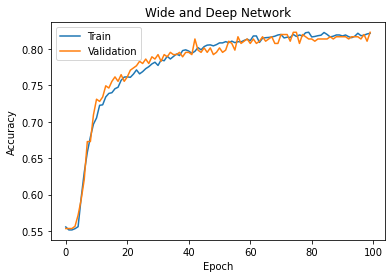

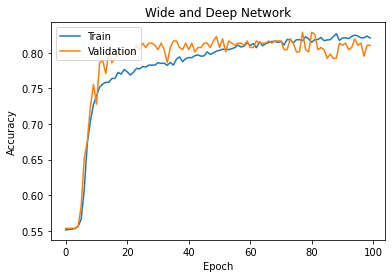

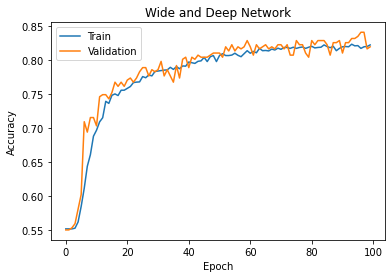

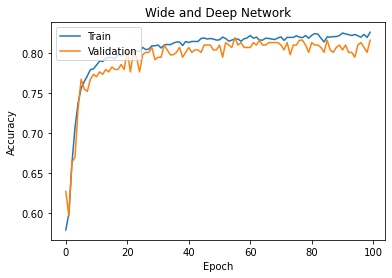

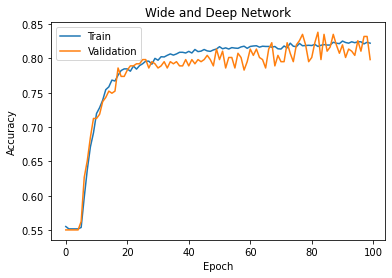

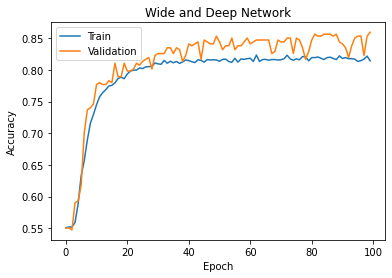

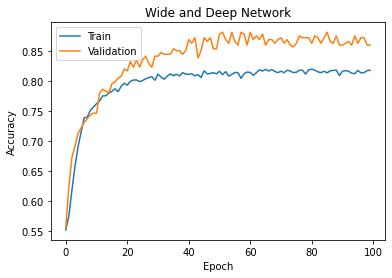

In [199]:
width = 2
depth_arr = [8, 4, 10]
run_wide_and_deep_network(width, depth_arr, X, y.values)

### <div style="color: green">Wide and Deep Network 3 </div>

Fold 1 Validation Accuracy: 0.8110
Fold 2 Validation Accuracy: 0.8073
Fold 3 Validation Accuracy: 0.7982
Fold 4 Validation Accuracy: 0.8104
Fold 5 Validation Accuracy: 0.8073
Fold 6 Validation Accuracy: 0.8257
Fold 7 Validation Accuracy: 0.7982
Fold 8 Validation Accuracy: 0.8104
Fold 9 Validation Accuracy: 0.8379
Fold 10 Validation Accuracy: 0.8777
Average Validation Accuracy: 0.8184


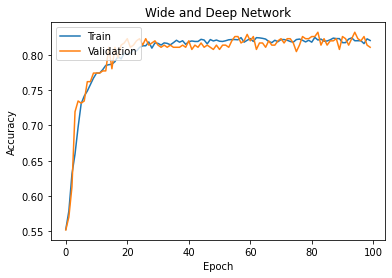

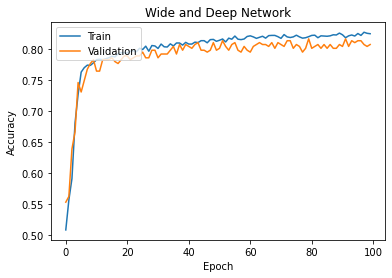

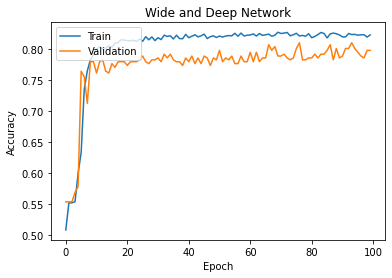

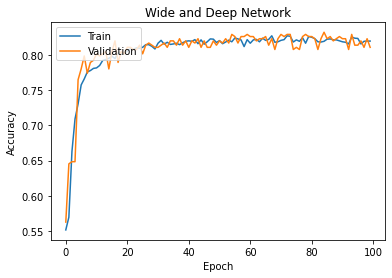

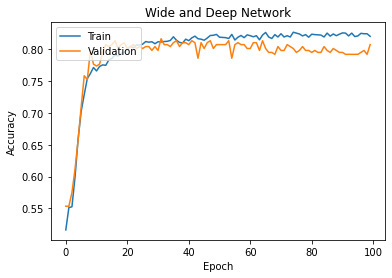

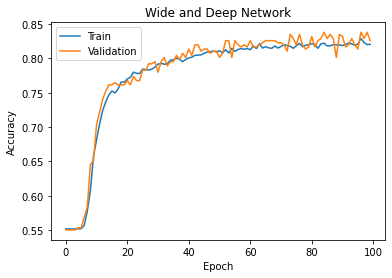

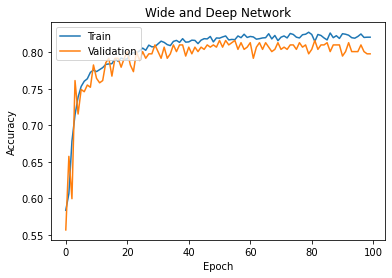

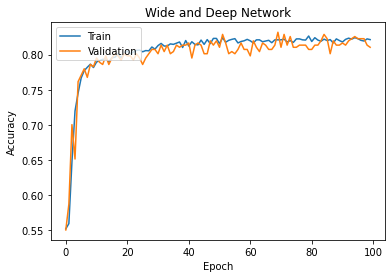

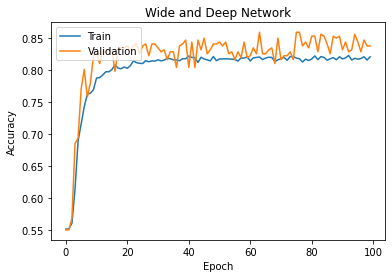

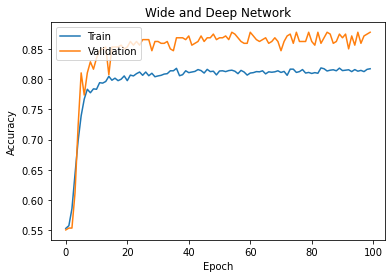

In [200]:
width = 6
depth_arr = [8, 8, 16]
run_wide_and_deep_network(width, depth_arr, X, y.values)

[2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 

### <div style="color: green">Wide and Deep Network 4 </div>
* The first network with 5 layers deep ended up having the best performance for our metric(basic accuracy). 

Fold 1 Validation Accuracy: 0.8049
Fold 2 Validation Accuracy: 0.8135
Fold 3 Validation Accuracy: 0.7890
Fold 4 Validation Accuracy: 0.8318
Fold 5 Validation Accuracy: 0.8073
Fold 6 Validation Accuracy: 0.8196
Fold 7 Validation Accuracy: 0.8012
Fold 8 Validation Accuracy: 0.8104
Fold 9 Validation Accuracy: 0.8410
Fold 10 Validation Accuracy: 0.8777
Average Validation Accuracy: 0.8196


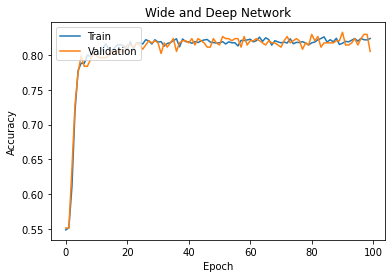

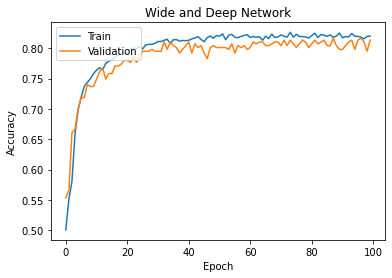

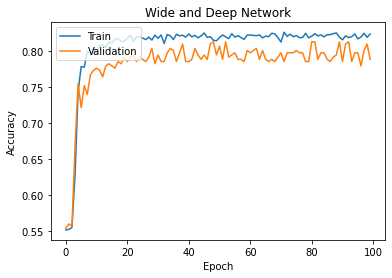

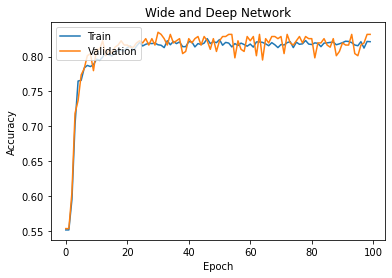

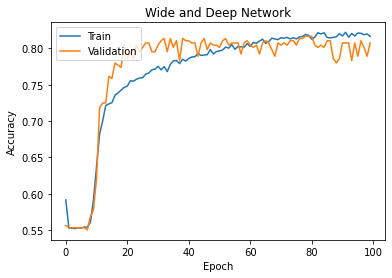

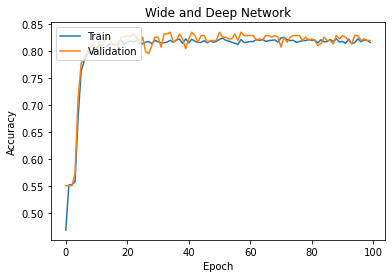

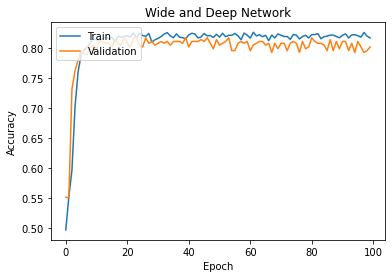

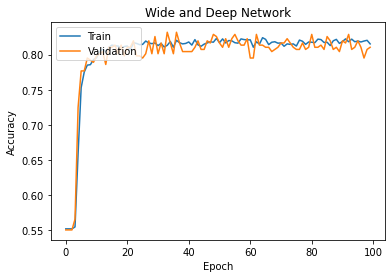

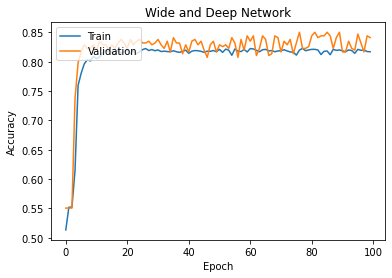

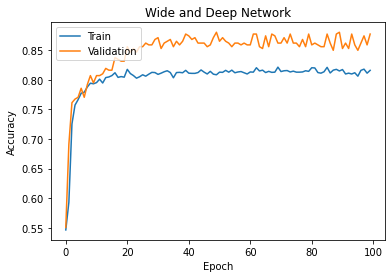

In [201]:
run_wide_and_deep_network(3, [8, 8, 8, 8, 16], X, y.values)

Fold 1 Validation Accuracy: 0.8140
Fold 2 Validation Accuracy: 0.8043
Fold 3 Validation Accuracy: 0.7859
Fold 4 Validation Accuracy: 0.8135
Fold 5 Validation Accuracy: 0.7951
Fold 6 Validation Accuracy: 0.8165
Fold 7 Validation Accuracy: 0.8012
Fold 8 Validation Accuracy: 0.8135
Fold 9 Validation Accuracy: 0.8440
Fold 10 Validation Accuracy: 0.8654
Average Validation Accuracy: 0.8153


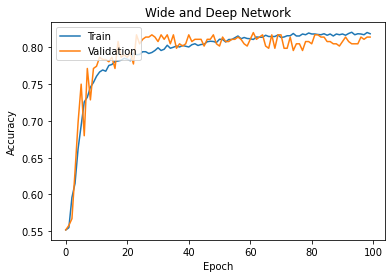

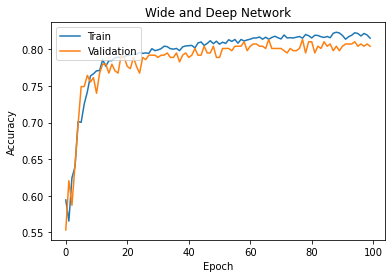

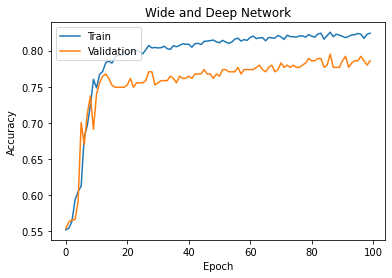

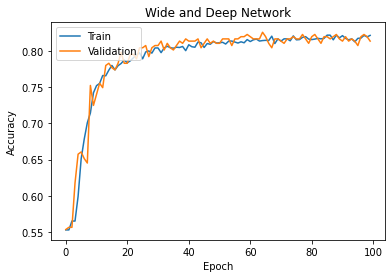

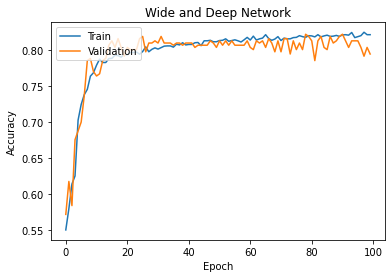

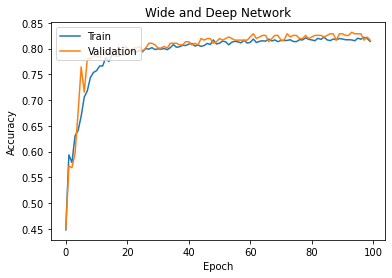

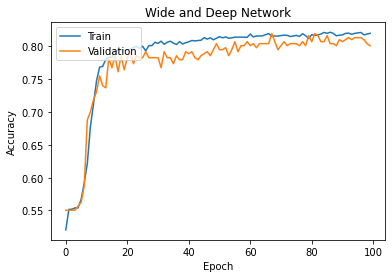

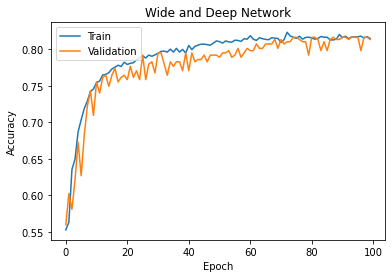

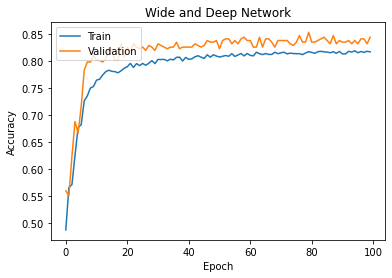

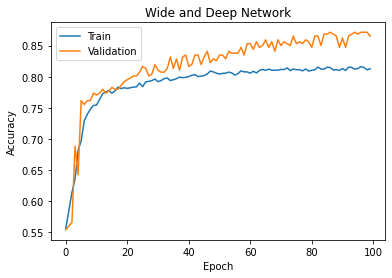

In [203]:
run_wide_and_deep_network(3, [8, 16], X, y.values)

[1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). .  

### Our best network
Our best network was our first, which was called like this:
```
run_wide_and_deep_network(3, [8, 8, 16], X, y.values)
```
which had a width of 3, and a depth of 3 layers, with 8, 8, and 16 nodes in each layer.

It achieved an accuracy of <div style="color: green">82.2%</div>

Now lets compare to a standard multi layer perceptron!

The performance of the multi layer perceptron was <div style="color: green">81.8%</div>

This is a pretty good result, but our wide and deep network was better! That means that all our efforts in making a wide and deep network were worth it! However, the multi layer perceptron was significantly faster, running on an M1 pro in 14.6 seconds, while the wide and deep network took 1 minute and 21 seconds to run.

In [204]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [205]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
get_acc(X, y, mlp)

0.8180931602894009

# Exceptional Work (1 points total)
(0.4) The overall quality of the report as a coherent, useful, complete and polished product will be reflected here. Did you support your reasons for creating cross categories? Did you include plots and provide interpretation? Did you justify your choice of metrics?

(0.6) Additional analysis
(5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.  Implement additional optimization models or statistical analysis.
 ( 7000 level students - options):
Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.
Use statistical methods to compare the performance of different models.  For classification tasks, you ight compare using the receiver operating characteristic and area under the curve. For regression tasks, you might use use Bland-Altman plots and residual variance calculations